# Classification, Probabilities, ROC curves, and Cost

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
from PIL import Image

In [3]:
from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [4]:
# Optimize hyper-'parameters' for model 'clf' w/ 'n_fold' cross validation across 'n_jobs' threads

def cv_optimize(clf, parameters, X, y, n_jobs=1, n_folds=5, score_func=None):
    if score_func:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, n_jobs=n_jobs, scoring=score_func)
    else:
        gs = GridSearchCV(clf, param_grid=parameters, n_jobs=n_jobs, cv=n_folds)
    gs.fit(X, y)
    print "BEST", gs.best_params_, gs.best_score_, gs.grid_scores_
    best = gs.best_estimator_
    return best

In [38]:
# Complete train-validate-test wrapper for sklearn

def do_classify(clf, parameters, indf, featurenames, targetname, target1val, mask=None, reuse_split=None, score_func=None, n_folds=5, n_jobs=1):
    
    # 1. Process input data frame
    subdf=indf[featurenames]
    X=subdf.values
    y=(indf[targetname].values==target1val)*1
    if mask.any() !=None:
        print "using mask"
        Xtrain, Xtest, ytrain, ytest = X[mask], X[~mask], y[mask], y[~mask]
    if reuse_split !=None:
        print "using reuse split"
        Xtrain, Xtest, ytrain, ytest = reuse_split['Xtrain'], reuse_split['Xtest'], reuse_split['ytrain'], reuse_split['ytest']
   
    # 2. Optimize hyper parameter
    if parameters:
        clf = cv_optimize(clf, parameters, Xtrain, ytrain, n_jobs=n_jobs, n_folds=n_folds, score_func=score_func)
        
    # 3. Train
    clf=clf.fit(Xtrain, ytrain)
    
    # 4. Test
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    
    print "############# based on standard predict ################"
    print "Accuracy on training data: %0.2f" % (training_accuracy)
    print "Accuracy on test data:     %0.2f" % (test_accuracy)
    print confusion_matrix(ytest, clf.predict(Xtest))
    print "########################################################"
    
    return clf, Xtrain, ytrain, Xtest, ytest

In [6]:
# Train-test split accuracy visualization wrapper

from matplotlib.colors import ListedColormap
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

def points_plot(ax, Xtr, Xte, ytr, yte, clf, mesh=True, colorscale=cmap_light, cdiscrete=cmap_bold, alpha=0.3, psize=10, zfunc=False):
    h = .02
    X=np.concatenate((Xtr, Xte))
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))

    if mesh:
        if zfunc:
            p0 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 0]
            p1 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
            Z=zfunc(p0, p1)
        else:
            Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        plt.pcolormesh(xx, yy, Z, cmap=cmap_light, alpha=alpha, axes=ax)
    ax.scatter(Xtr[:, 0], Xtr[:, 1], c=ytr-1, cmap=cmap_bold, s=psize, alpha=alpha,edgecolor="k")

    yact=clf.predict(Xte)
    ax.scatter(Xte[:, 0], Xte[:, 1], c=yte-1, cmap=cmap_bold, alpha=alpha, marker="s", s=psize+10)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    
    return ax,xx,yy

In [7]:
# Plot classification decision boundary in form of probability contours

def points_plot_prob(ax, Xtr, Xte, ytr, yte, clf, colorscale=cmap_light, cdiscrete=cmap_bold, ccolor=cm, psize=10, alpha=0.1, prob=True):
    ax,xx,yy = points_plot(ax, Xtr, Xte, ytr, yte, clf, mesh=False, colorscale=colorscale, cdiscrete=cdiscrete, psize=psize, alpha=alpha) 
    if prob:
        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    else:
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=ccolor, alpha=.2, axes=ax)
    cs2 = plt.contour(xx, yy, Z, cmap=ccolor, alpha=.6, axes=ax)
    plt.clabel(cs2, fmt = '%2.1f', colors = 'k', fontsize=14, axes=ax)
    return ax 

## Setting up the data

In [8]:
dfhw=pd.read_csv("https://dl.dropboxusercontent.com/u/75194/stats/data/01_heights_weights_genders.csv")
print dfhw.shape
dfhw.head()

(10000, 3)


,Gender,Height,Weight
0,Male,73.847017,241.893563
1,Male,68.781904,162.310473
2,Male,74.110105,212.740856
3,Male,71.730978,220.042470
4,Male,69.881796,206.349801


We sample 500 points from 10,000, since we actually want to see trends clearly on the plots

In [31]:
df=dfhw.sample(500, replace=False)
np.sum(df.Gender=="Male")

240

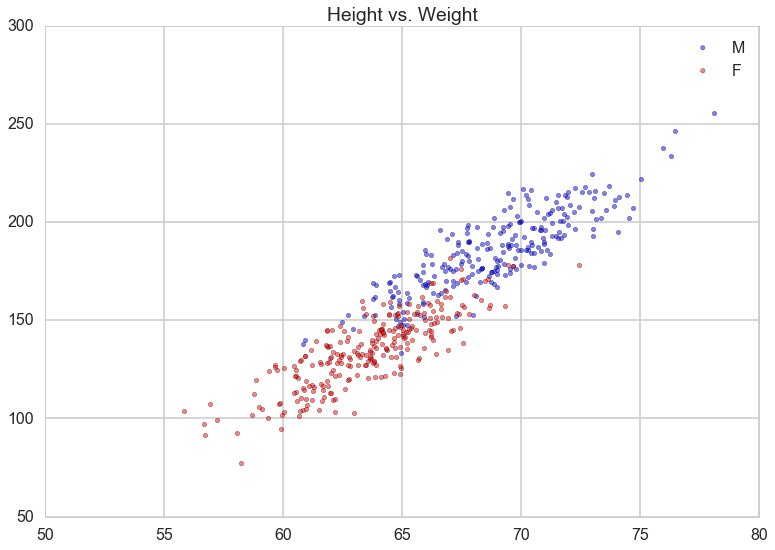

In [34]:
plt.scatter(df[df.Gender == "Male"].Height, df[df.Gender == "Male"].Weight, label="M", c='b', alpha=0.5)
plt.scatter(df[df.Gender == "Female"].Height, df[df.Gender == "Female"].Weight, label="F", c='r', alpha=0.5)
plt.title("Height vs. Weight")
plt.legend()

We split the data into training and test sets...

In [36]:
# Indexes
itrain, itest = train_test_split(xrange(df.shape[0]), train_size=0.6)
mask=np.ones(df.shape[0], dtype='int')
# Boolean mask on chosen Indexes
mask[itrain]=1
mask[itest]=0
mask = (mask==1)
# Train: T, Test: F
mask[:10]

array([False,  True, False,  True,  True, False,  True,  True, False, False], dtype=bool)

## Logistic regression
Notice that its L2 regularized....
<img src='http://www.chioka.in/wp-content/uploads/2013/12/L1-vs-L2-properties-regularization.png'>

using mask
BEST {'C': 0.01} 0.923333333333 [mean: 0.91333, std: 0.03904, params: {'C': 0.001}, mean: 0.92333, std: 0.02907, params: {'C': 0.01}, mean: 0.92333, std: 0.02907, params: {'C': 0.1}, mean: 0.92000, std: 0.02661, params: {'C': 1}, mean: 0.92000, std: 0.02661, params: {'C': 10}, mean: 0.92000, std: 0.02661, params: {'C': 100}, mean: 0.92000, std: 0.02661, params: {'C': 1000}, mean: 0.92000, std: 0.02661, params: {'C': 10000}]
############# based on standard predict ################
Accuracy on training data: 0.92
Accuracy on test data:     0.92
[[103   4]
 [ 12  81]]
########################################################


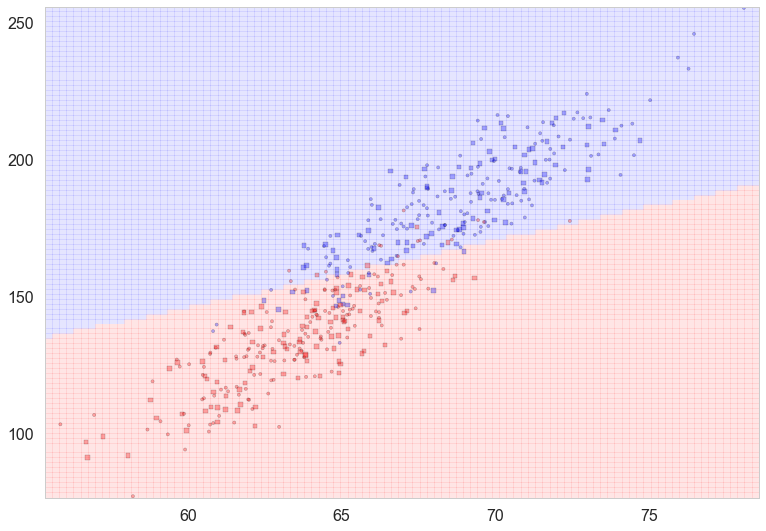

In [39]:
from sklearn.linear_model import LogisticRegression

clflog = LogisticRegression()
parameters = {"C": [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}

clflog, Xtrain, ytrain, Xtest, ytest=do_classify(clflog, parameters, df, ['Height','Weight'],'Gender', "Male", mask=mask)
Xtr=np.concatenate((Xtrain, Xtest))

plt.figure()
ax=plt.gca()
points_plot(ax, Xtrain, Xtest, ytrain, ytest, clflog);

In `sklearn`, `clf.predict(test_data)` makes predictions on the assumption that a **0.5 probability threshold is the appropriate thing to do.**   
We may want to vary the threshold, eg. predicting if a tumor is malignant - better to stay on a side of caution.

In [40]:
clflog.predict(Xtest)

array([1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1,
       0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0])

The probabilities output by the classifier can be accessed as below.

In [44]:
# Probability for each sample being a 1/0
clflog.predict_proba(Xtest)
# P(0) = 1-P(1)

array([[  2.39610377e-01,   7.60389623e-01],
       [  7.66110439e-01,   2.33889561e-01],
       [  1.39165777e-01,   8.60834223e-01],
       [  9.14602677e-01,   8.53973232e-02],
       [  9.75034254e-01,   2.49657461e-02],
       [  9.97087832e-01,   2.91216766e-03],
       [  9.97699866e-01,   2.30013442e-03],
       [  6.93260990e-02,   9.30673901e-01],
       [  7.28965568e-01,   2.71034432e-01],
       [  8.61645835e-02,   9.13835416e-01],
       [  6.60546942e-01,   3.39453058e-01],
       [  9.95474633e-01,   4.52536680e-03],
       [  9.97208573e-01,   2.79142652e-03],
       [  1.36869347e-03,   9.98631307e-01],
       [  5.79910445e-01,   4.20089555e-01],
       [  8.72150591e-01,   1.27849409e-01],
       [  9.93245801e-01,   6.75419933e-03],
       [  7.21217910e-01,   2.78782090e-01],
       [  1.44397459e-02,   9.85560254e-01],
       [  9.94854841e-01,   5.14515928e-03],
       [  6.16591954e-02,   9.38340805e-01],
       [  9.83418471e-01,   1.65815292e-02],
       [  

The second column (`[:,1]` in numpy parlance, i.e. skip 1) gives the probability that the sample is a 1 (or +ive), here Male.

In [45]:
# Probability for each sample being a 1
clflog.predict_proba(Xtest)[:,1]

array([  7.60389623e-01,   2.33889561e-01,   8.60834223e-01,
         8.53973232e-02,   2.49657461e-02,   2.91216766e-03,
         2.30013442e-03,   9.30673901e-01,   2.71034432e-01,
         9.13835416e-01,   3.39453058e-01,   4.52536680e-03,
         2.79142652e-03,   9.98631307e-01,   4.20089555e-01,
         1.27849409e-01,   6.75419933e-03,   2.78782090e-01,
         9.85560254e-01,   5.14515928e-03,   9.38340805e-01,
         1.65815292e-02,   1.84420650e-03,   7.52991357e-02,
         1.76046491e-02,   4.14728964e-02,   7.41041809e-01,
         7.34814519e-02,   1.63156998e-01,   2.61221423e-03,
         7.44789705e-01,   3.45559429e-02,   7.56598456e-02,
         9.90874663e-01,   3.84490406e-01,   9.98726505e-01,
         9.59250558e-02,   2.50674361e-01,   4.65409549e-02,
         7.50168419e-04,   7.29750639e-01,   4.26992404e-02,
         1.82593399e-01,   9.17410120e-01,   5.60197527e-02,
         1.16047736e-03,   1.11251859e-02,   1.34693384e-02,
         7.56685273e-01,

Lots of sure females and sure males when you plot the probability of being a male:

(array([ 72.,  21.,  10.,   6.,   6.,   7.,   4.,  13.,  10.,  51.]),
 array([  5.11782127e-04,   1.00333254e-01,   2.00154727e-01,
          2.99976199e-01,   3.99797671e-01,   4.99619144e-01,
          5.99440616e-01,   6.99262088e-01,   7.99083560e-01,
          8.98905033e-01,   9.98726505e-01]),
 <a list of 10 Patch objects>)

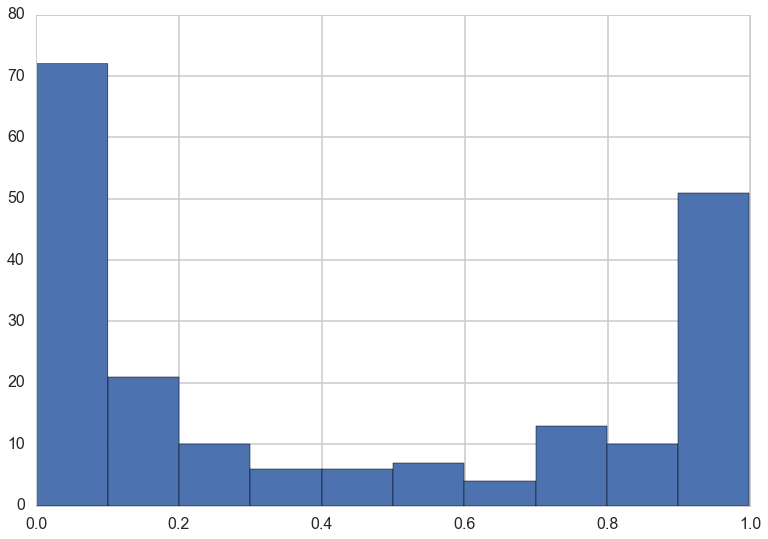

In [47]:
plt.hist(clflog.predict_proba(Xtest)[:,1])

We can plot the probability contours: these are rather tight!

/Users/Sachin/anaconda/lib/python2.7/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/Users/Sachin/anaconda/lib/python2.7/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


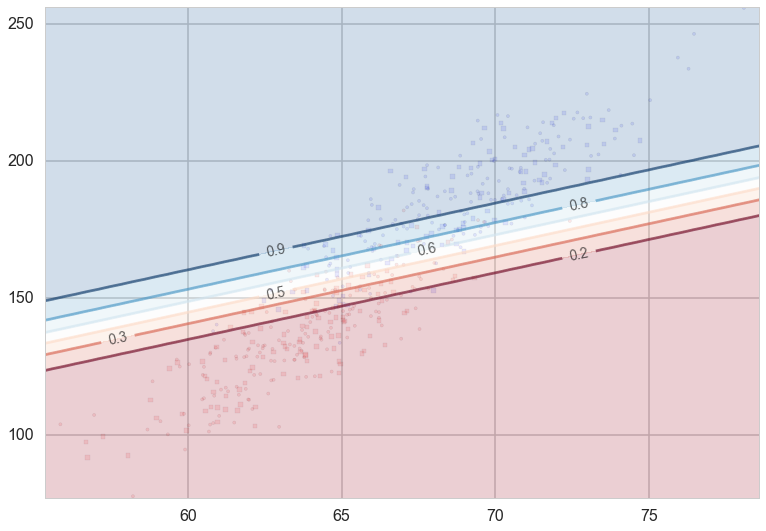

In [48]:
plt.figure()
ax=plt.gca()
points_plot(ax, Xtrain, Xtest, ytrain, ytest, clflog, mesh=False, alpha=0.001);
points_plot_prob(ax, Xtrain, Xtest, ytrain, ytest, clflog);

The score function of the estimator is used to evaluate a parameter setting. These are the sklearn.metrics.accuracy_score for classification and sklearn.metrics.r2_score for regression. For some applications, other scoring functions are better suited (for example in unbalanced classification, the accuracy score is often uninformative). We can pass other scorers to `GridSearchCV`.

In [50]:
clflog.score(Xtest, ytest)

0.92000000000000004

## SVM
Lets do a linear SVM instead. As mentioned in the last lab, SVM is a discriminant classifier... it is not probabilistic.  
**We can use the same wrapper functions above for any `sklearn` model!**

In [51]:
from sklearn.svm import SVC
clfsvm = SVC(kernel="linear")
# Linear -> Can leverage rbf kernel and kernel trick for finding dot products w/o first computing points

using mask
BEST {'C': 1000} 0.92 [mean: 0.91333, std: 0.03059, params: {'C': 0.001}, mean: 0.91667, std: 0.02765, params: {'C': 0.01}, mean: 0.91333, std: 0.03034, params: {'C': 0.1}, mean: 0.91000, std: 0.02680, params: {'C': 1}, mean: 0.91333, std: 0.02446, params: {'C': 10}, mean: 0.91333, std: 0.03715, params: {'C': 100}, mean: 0.92000, std: 0.03233, params: {'C': 1000}]
############# based on standard predict ################
Accuracy on training data: 0.92
Accuracy on test data:     0.92
[[102   5]
 [ 12  81]]
########################################################


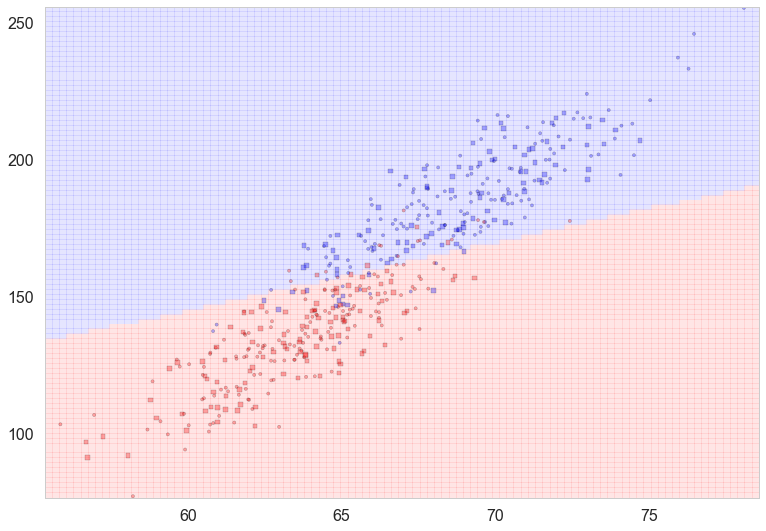

In [52]:
parameters = {"C": [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
clfsvm, Xtrain, ytrain, Xtest, ytest=do_classify(clfsvm, parameters, df, ['Height','Weight'],'Gender', "Male", mask=mask)
Xtr=np.concatenate((Xtrain, Xtest))
plt.figure()
ax=plt.gca()
points_plot(ax, Xtrain, Xtest, ytrain, ytest, clfsvm);

This there is no `predict_proba`. Instead, we get to use `decision_function`, which give us whatever the said classifier is using to discriminate... i.e. distance from the boundary

In [53]:
clfsvm.decision_function(Xtest)

array([  6.98369278,  -5.72699004,  10.67772887, -12.21466117,
       -19.22154815, -31.06010512, -32.38436712,  14.8309015 ,
        -4.66094566,  13.60879902,  -2.88006731, -28.65174828,
       -31.26430861,  36.73663991,  -1.02008726,  -9.70924998,
       -26.55903069,  -4.48180437,  23.64312739, -28.01618709,
        15.54645259, -21.55143958, -33.44464054, -12.92893298,
       -21.21780733, -16.25632535,   6.46634282, -13.10861462,
        -8.18259919, -31.66347125,   6.64315947, -17.45487791,
       -12.92359729,  26.32876526,  -1.76673913,  37.11585722,
       -11.5314054 ,  -5.2468263 , -15.80260263, -38.37867045,
         6.24717418, -16.26591872,  -7.47215297,  13.71626671,
       -14.76025848, -36.11470999, -23.84595283, -22.65277441,
         6.954329  ,  -0.93787844,  -9.07265952, -16.31602055,
         6.98338248, -27.66466019,  31.14794646,   6.03420774,
         1.47799933, -11.93061646,  25.67144302,  -1.73636012,
       -21.43859787, -36.71830381,   6.9759065 ,   3.72

We can plt a histogram. In terms of distance from the separator, we can see that most samples on either side are a middling distance away. This is different from the probability diagram

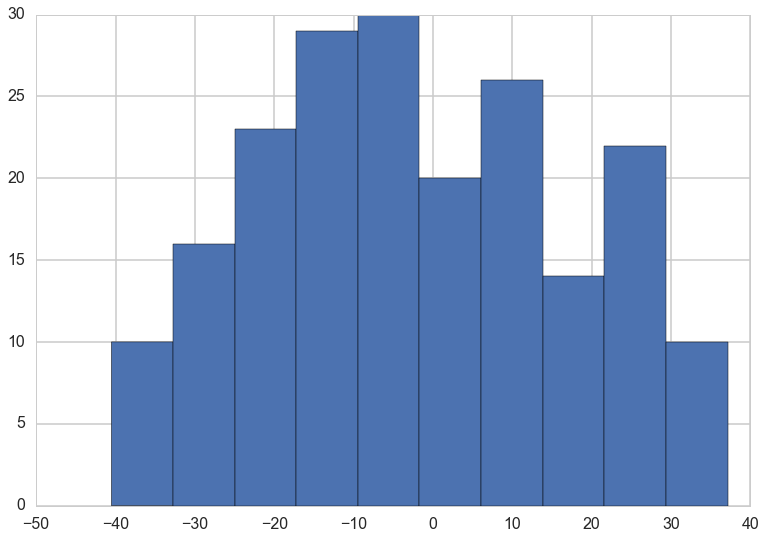

In [55]:
plt.hist(clfsvm.decision_function(Xtest));

Its clearer with a plot of the `decision_function` on the plane...

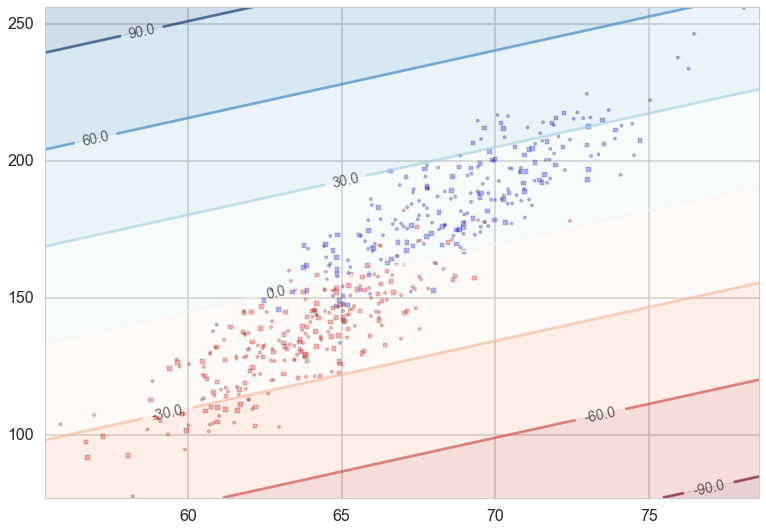

In [56]:
plt.figure()
ax=plt.gca()
points_plot(ax, Xtrain, Xtest, ytrain, ytest, clfsvm, mesh=False);
points_plot_prob(ax, Xtrain, Xtest, ytrain, ytest, clfsvm, prob=False);

The decision function can be used to plot the margins of the SVM.

In [63]:
# From Jake Vanderplas's ESAC notebook
def plot_svc_decision_function(clf, ax=None):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    x = np.linspace(plt.xlim()[0], plt.xlim()[1], 30)
    y = np.linspace(plt.ylim()[0], plt.ylim()[1], 30)
    Y, X = np.meshgrid(y, x)
    P = np.zeros_like(X)
    for i, xi in enumerate(x):
        for j, yj in enumerate(y):
            P[i, j] = clf.decision_function([xi, yj])
    return ax.contour(X, Y, P, colors='k',
                      levels=[-1, 0, 1], alpha=0.5,
                      linestyles=['--', '-', '--'])

and we can also access the support vectors....

/Users/Sachin/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Users/Sachin/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Users/Sachin/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single s

(125, 225)

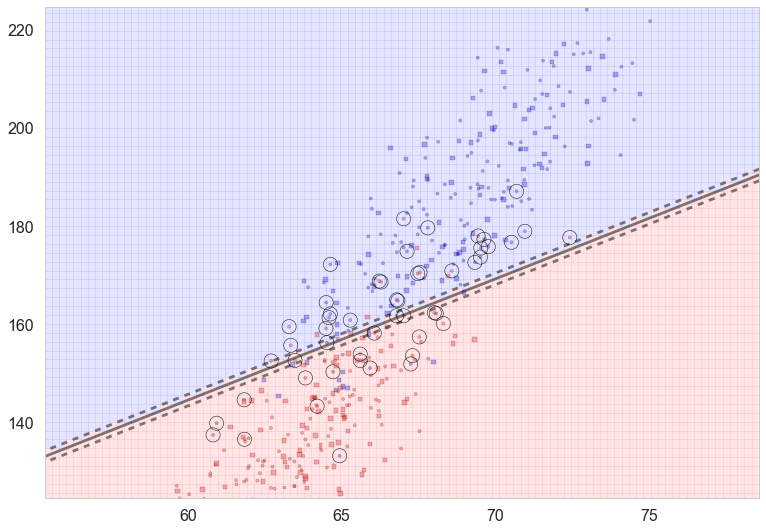

In [64]:
plt.figure()
ax=plt.gca()
points_plot(ax, Xtrain, Xtest, ytrain, ytest, clfsvm);
plot_svc_decision_function(clfsvm, ax)
ax.scatter(clfsvm.support_vectors_[:, 0], clfsvm.support_vectors_[:, 1],s=200, facecolors='none')
plt.ylim([125,225])